In [1]:
%matplotlib inline

from matplotlib import rc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def setup_plots():
    rc('text', usetex=False)
    rc('font', size=17)
    
    return

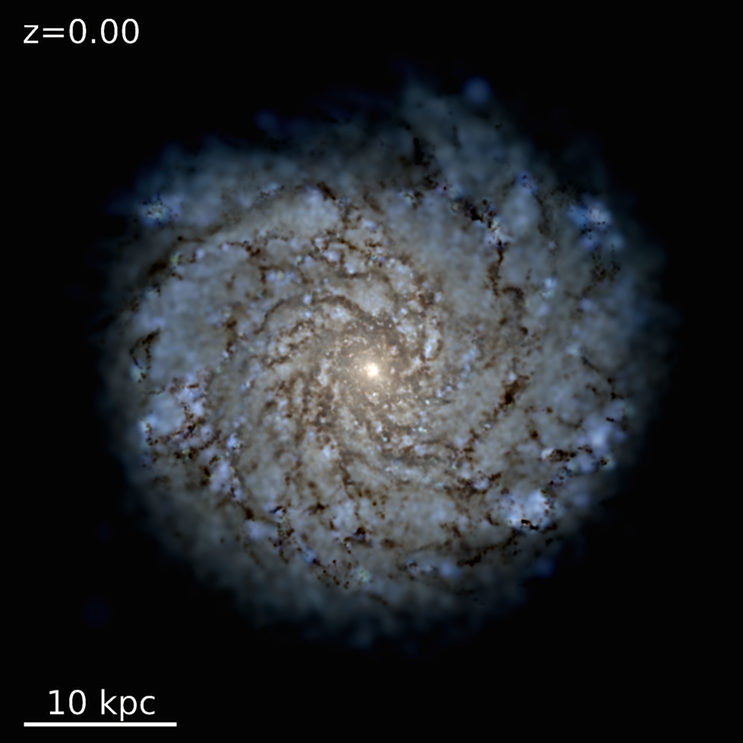

## Dataset Loading 

In [2]:
# load 3 datasets
all_df = {}

filenames = {'live-simulation' : './input/m11i_fire2_abundances.dat',
             'model-one'   : './input/m11i_fire2_AT_abundances.dat',
             'model-two' : './input/m11i_NuGird_AT_abundances.dat'}

for k in filenames.keys():
    all_df[k] = pd.read_csv(filenames[k], delim_whitespace=True)

In [52]:
def weighted_percentile(values, percentiles, weight=None, values_sorted=False):
    """
        As taken from:
        https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy

        Very close to np.percentile, but supports weights.
        
     NOTE: quantiles should be in [0, 1]!
    :param values: np.array with data
    :param quantiles: array-like with many quantiles needed
    :param weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of initial array
    :return: np.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(percentiles / 100.0)
    if weight is None:
        weight = np.ones(len(values))
    weight = np.array(weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), 'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        weight = weight[sorter]

    weighted_quantiles = np.cumsum(weight) - 0.5 * weight
    weighted_quantiles /= np.sum(weight)

    return np.interp(quantiles, weighted_quantiles, values)

def compute_statistics(values, weights=None, limits = [-np.inf, np.inf]):
    """
    Compute a set of statistics for a given set of values with optional
    weights and limits. 
    
    Provide an empty set of values or "None" to see which statistics
    are computed
    
    Parameters
    ----------
    values    : 1D-array
                Array of values to compute. Supply an empty array or 
                'None' to see what statistics are computed.
    weights   : 1D array (optional)
                Optional weights for values. Must be same length as values.
                Default : None
    limits    : list, tuple (optional)
                Minimum and maximum values to consider (2D list, tuple).
                Default considers all values. Default: [-np.inf, np.inf].
                
    Returns:
    --------
    stats     : dictionary
                Dictionary of computed statistics. Provide an empty 'values'
                to see what statistics are computed.
    """
    
    #
    # construct default dictionary. This needs to be updated if
    # new stats are computed below.
    #
    stats = {'limits' : [], 'number' : 0, 'median' : 0, 'mean' : 0,
             '1-sigma' : 0, '2-sigma' : 0, '3-sigma' : 0,
             '1-sigma_range' : 0, '2-sigma_range' : 0, '3-sigma_range' : 0,
             'IQR' : 0, 'inter_quartile_range' : 0, 'inter_decile_range' : 0,
             'mean_median_diff' : 0,
             'variance' : 0,
             'std': 0, 'min' : 0, 'max' : 0}
    #
    # percentiles to compute, with string formatter 
    # to eliminate trailing zeros and decimals in percentile
    #
    # e.g. percentile_0.135  and percentile_10
    #
    percentiles_list = [0.135, 2.275, 10, 15.865, 25, 50, 75, 84.135, 90, 97.725, 99.865]
    perc_string = lambda x : ("%.3f"%(x)).rstrip("0").rstrip('.')
    for pval in percentiles_list:
        stats['percent_' + perc_string(pval)] = 0
        
    # some shorthand percentiles for the 1,2,3 sigma percentiles
    for k in ['0.1','2','16','84','98','99']:
        stats['percent_' + k] = 0

        
    
    # don't throw an error if values is empty
    if values is None or len(values) == 0:
        return stats
    
    # select out based on limits
    mask = (values >= limits[0] ) * (values < limits[-1])
    _values = values[mask]
    
    nvalues = np.size(_values)
    if weights is None:
        _weights = np.ones(nvalues)
    else:
        
        if len(weights) != len(mask):
            print("Weights must have same size (%i) as `values` array (%i)"%(np.size(weights),np.size(values)))
            raise ValueError
            
        _weights = weights[mask]
    
    stats['limits'] = limits
    stats['number'] = nvalues

        
    stats['mean']      = np.average(_values, weights=_weights)
    stats['variance']  = np.sum(weights/np.sum(weights) * (_values - stats['mean'])**2)
    stats['std']       = np.sqrt(stats['variance'])
    
    for pval in percentiles_list:
        stats['percent_' + perc_string(pval)] =\
                                  weighted_percentile(_values,pval,_weights)
        
    stats['median'] = stats['percent_50']
    
    # copy relevant percentiles into 1, 2, and 3 sigma interval pairs
    stats['1-sigma'] = [stats['percent_15.865'], stats['percent_84.135']]
    stats['2-sigma'] = [stats['percent_2.275'] , stats['percent_97.725']]
    stats['3-sigma'] = [stats['percent_0.135'] , stats['percent_99.865']]
    
    # and make some shorthand percentiles for these
    for k1, k2 in [ ('16','15.865'), ('84','84.135'),('2','2.275'),('98','97.725'),('0.1','0.135'),('99','99.865')]:
        stats['percent_'+k1] = stats['percent_' + k2]    
    
    #
    # derived statistics giving ranges
    #
    for k in ['1-sigma','2-sigma','3-sigma']:
        stats[k + '_range'] = stats[k][1] - stats[k][0]
    stats['IQR']                  = stats['percent_75'] - stats['percent_25']
    stats['inter_quartile_range'] = stats['IQR']
    stats['inter_decile_range']   = stats['percent_90'] - stats['percent_10']
    stats['mean_median_diff']     = stats['mean'] - stats['median']
    
    # min, max
    stats['min'] = np.min(_values)
    stats['max'] = np.max(_values)
        
    
    return stats

def binned_statistics(values_x, values_y, limits = None, nbins = 100,
                      bins = None, weights = None,
                      y_limits = [-np.inf, np.inf],
                      empty_value = np.nan,
                      return_binned_values = False):
    """
    Computes binned statistics of `values_y` as a function of `values_x` with optional
    weights. 
    
    Parameters :
    -------------
    values_x, values_y : 1D array
            1D arrays of same length to compute statistics on. Bins `values_y` as 
            a function of `values_x`. 
            
    limits : list, tuple, optional
            Min and max values in x dimension to bin along. If not provided,
            defaults to min and max values of `values_x`. 
            Ignored if `bins` provided. Default : None
            
    nbins   : int, optional
            Number of bins. Ignored if `bins` provided. Default : 100
            
    bins    : 1D array, optional
            Bins in `values_x` to use. Overrides `limits` and `nbins` arguements.
            Default : None
            
    weights : 1D array, optional
            Weights to use when computing statistics. Must be same size as 
            `values_x`. Default : None
            
    y_limits : list, tuple, optional
            Limits for `values_y` below / above which these values will be
            ignored. Default is to accept all `values_y`. Default : [-np.inf,np.inf]
            
    empty_value : optional
             If a bin is empty, stats for that bin (except `number`)
             are set to this value. Default is `np.nan` to mask out 
             when plotting.
            
    return_binned_values : bool, optional
            Return a list of the `values_y` in each bin as well in the 
            output dictionary. Default : False.
    
    Returns:
    ---------
    """
    
    if bins is None:
        if limits is None:
            limits = [np.min(values_x), np.max(values_x)]
        bins = np.linspace(limits[0], limits[-1], nbins+1)      
    else:
        limits = [bins[0], bins[-1]]
        nbins  = np.size(bins)
    

    mask = (values_x >= limits[0]) * (values_x < limits[-1])
    _values_x = values_x[mask]
    _values_y = values_y[mask]
    
    if weights is None:
        _weights = np.ones(np.size(_values_x))
    else:
        _weights = weights[mask]
        
    # get kwargs of statistics that will be computed
    # to build dictionary of lists to house the binned stats
    empty_stats = compute_statistics(None)
    
    binned_stats = {'bins'        : bins,      # bin edges
                    'lbins'       : bins[:-1], # left bin edges
                    'rbins'       : bins[1:],  # right bin edges
                    'bins_mid'    : 0.5*(bins[:-1]+bins[1:]), # bin centers
                    'bins_diff'   : (bins[1:]-bins[:-1]),     # db
                    'bin_limits'  : limits,  
                    'y_limits'    : y_limits,
                    'total_number': np.size(_values_x),
                    'binned_y'    : [],    # empty for now, optional to generate
                    'nbins'       : nbins}
    
    #
    # initialize the statistics (better than appending to a list)
    #
    
    # stats to skip and not save in binned statistic.
    # these are all lists / tuples and redundant with other
    # information
    skip_stats = ['limits','1-sigma','2-sigma','3-sigma'] 
        
    for k in empty_stats.keys():
        if k in skip_stats:
            continue
        binned_stats[k] = np.zeros(binned_stats['nbins']-1)
        
    if return_binned_values:
        binned_stats['binned_y'] = [None] * binned_stats['nbins']
    
    #
    # generate the masks for all of the points
    #
    bin_indexes = np.digitize(_values_x, bins, right = False)
    #print(binned_stats['nbins'],np.min(bin_indexes),np.max(bin_indexes))
    for i in np.arange(binned_stats['nbins']-1):
        #
        # Generate mask and get y values in this bin
        #
        mask     = bin_indexes == i
        masked_y = _values_y[mask]
        
        #
        # compute and save all stats for this bin.
        #
        stats = compute_statistics(masked_y, weights = _weights[mask],
                                   limits = y_limits)
        
        if stats['number'] == 0:
            #
            # Set the stats to the empty value
            # (by default, np.nan to mask out when plotting)
            #
            for k in stats.keys():
                if k in skip_stats:
                    continue
                binned_stats[k][i] = empty_value
            binned_stats['number'][i] = 0
            
        else:
            # save all stats (except the skipped ones)
            for k in stats.keys():
                if k in skip_stats:
                    continue
                # print(i,k,stats[k])
                binned_stats[k][i] = stats[k]
        
        # save masked y values if requested
        if return_binned_values:
            binned_stats['binned_y'][i] = masked_y
    
    
    return binned_stats

/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


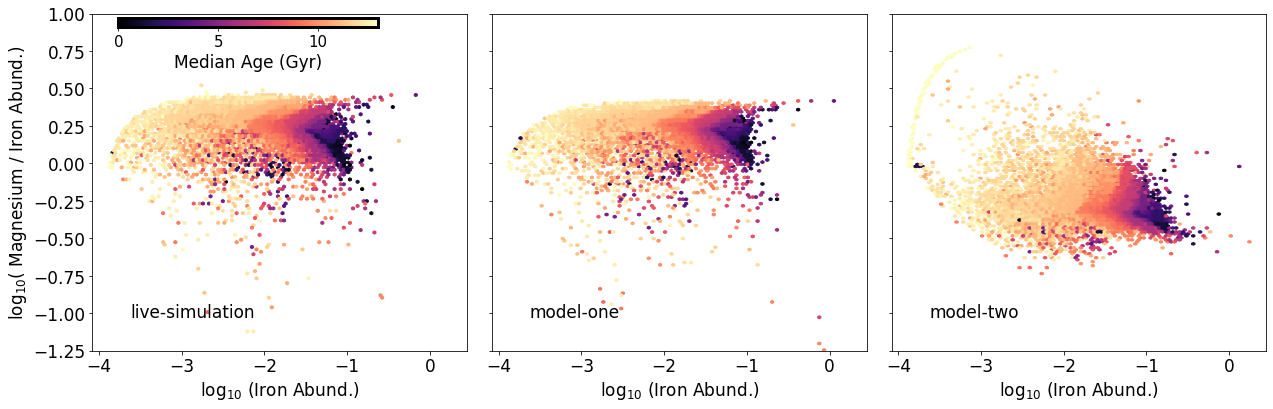

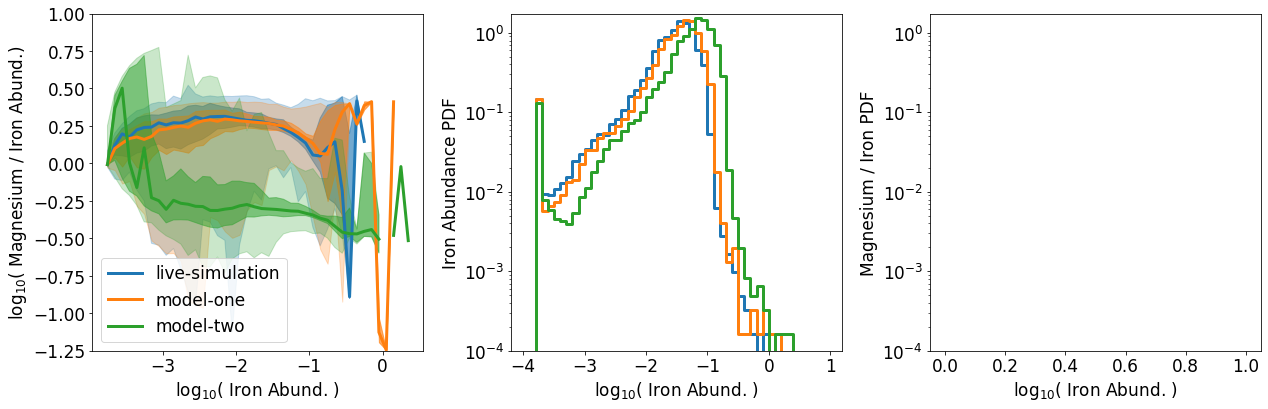

In [53]:
def weighted_median(vals_array):
    """
    Take in a list / array of vals where we assume each element
    has two numbers :  [(1,2), (3,4)....] etc. where
    the first value is the value of interest and the second
    is the weighting
    """
    
    weight = np.array([_x[0] for _x in vals_array])
    val    = np.array([_x[1] for _x in vals_array])
    
    return weighted_percentile(val, 50.0, weight=weight)

setup_plots()
from matplotlib.colors import LogNorm


nrow = 1
ncol = 3
fs   = 6

fig,all_ax = plt.subplots(nrow,ncol,sharex=True,sharey=True)
fig.set_size_inches(ncol*fs,nrow*fs)
fig.subplots_adjust(wspace=0,hspace=0)

axi=axj=0
for name in all_df.keys():
    if nrow > 1:
        axindex = (axi,axj)
    else:
        axindex = axj
    ax = all_ax[axindex]

    # 
    # For this plot, want to color 2D grid points NOT by count
    # or a simple average of a quantity, but by the weighted median.
    # In this case, we want the mass-weighted age of the stars.
    #
    # Using a custom reduction function to do this, passing
    # a list of tuples containing the weight value and the
    # value to compute the weighted median of
    #
    C = [c for c in zip(all_df[name].mass, all_df[name].age)]
    im=ax.hexbin(all_df[name].fe_over_h,
                 all_df[name].mg_over_fe,
                 C = C,                             # values to pass to reduction function
                 reduce_C_function=weighted_median, # reduction function
                 vmin = 0.0, 
                 vmax = 13.0,
                 gridsize=100,               
                 cmap='magma')
    if axj == 0:
        im1 = im
    
    xy = (0.1,0.1)
    ax.annotate(name, xy=xy,xytext=xy,xycoords='axes fraction')
    
    axj = axj + 1
    if axj >= ncol:
        axi = axi+1
        axj = 0


all_ax[0].set_ylabel(r'log$_{10}$( Magnesium / Iron Abund.)')
for i in range(3):
    all_ax[i].set_xlabel(r'log$_{10}$ (Iron Abund.)')
    all_ax[i].set_ylim(-1.25,1.0)
    
def _set_colorbar_properties(image, axes_coords, color = 'white'):
   
        
    return cbar
    
left = 0.1
upper = 0.91
cb_ax = fig.add_axes([left,upper,0.2,0.02])
cbar = fig.colorbar(im1, cax=cb_ax,orientation='horizontal')        
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(3)
cbar.ax.tick_params(axis='both', colors='black',labelsize=15) #,weight='bold') 
cbar.set_label("Median Age (Gyr)")
plt.tight_layout()
plt.show()

plt.close()
#
#
#

fig,all_ax = plt.subplots(nrow,ncol)
fig.set_size_inches(ncol*fs,nrow*fs)
#fig.subplots_adjust(hspace=0)
        
#
# Compare all 3 datasets using running medians
# and 1 and 3 sigma shading around the median
#
for i,name in enumerate(all_df.keys()):

    stats = binned_statistics(all_df[name].fe_over_h, all_df[name].mg_over_fe,
                              bins=np.arange(-4,1.01,0.1), weights = all_df[name].mass)
    
    color = 'C%i'%(i)
    all_ax[0].plot(stats['bins_mid'], stats['median'], lw = 3, color = color,
                   label = name, ls = '-')
    all_ax[0].fill_between(stats['bins_mid'], stats['percent_16'], stats['percent_84'],
                           color = color, alpha = 0.5)
    
    all_ax[0].fill_between(stats['bins_mid'], stats['percent_0.1'], stats['percent_99'],
                           color = color, alpha = 0.25)    
    
    all_ax[1].step(stats['bins_mid'], stats['number']/(1.0*np.sum(1.0*stats['number'])) / stats['bins_diff'], lw = 3, where='mid')
    #all_ax[1].plot(stats['bins_mid'], stats['1-sigma_range'], lw = 3, color = color)
    #all_ax[2].plot(stats['bins_mid'], stats['3-sigma_range'], lw = 3, color = color)
    

#ax.plot(stats['bins_mid'], stats['median'])
#ax.fill_between(stats['bins_mid'], stats['percent_16'], 
#                                    stats['percent_84'], alpha = 0.5,color = 'black')
#ax.fill_between(stats['bins_mid'], stats['percent_0.1'], 
#                                    stats['percent_99'], alpha = 0.5,color = 'grey')
#ax.set_xlim(-4,1)
#ax.set_ylim(-0.6,0.9)
#plt.tight_layout()
all_ax[0].legend(loc='lower left')

for i in range(3):
    all_ax[i].set_xlabel(r'log$_{10}$( Iron Abund. )')
all_ax[0].set_ylabel(r'log$_{10}$( Magnesium / Iron Abund.)')
all_ax[0].set_ylim(-1.25,1.0)
all_ax[1].semilogy()
all_ax[2].semilogy()
all_ax[1].set_ylim(1.0E-4,1.75)
all_ax[2].set_ylim(1.0E-4,1.75)
all_ax[1].set_ylabel(r'Iron Abundance PDF')
all_ax[2].set_ylabel(r'Magnesium / Iron PDF')
plt.tight_layout()

In [93]:
%%latex
What is the likelihood of an observed data set with assumed Gaussian errors given these models?

$$L = \prod_{i}^{n} L_{i}$$
$$L_{i} = \int dX \frac{dP}{dX} \times \left[\frac{1}{\sqrt{2\pi}\sigma_i} exp\left(\frac{-(X-X_i)^2}{2\sigma_i^2}\right) \right]$$
where $j$ indexes the model star, for all $m$ model stars, and $i$ indexes the observed star for $n$ observations.
$dP/dX$ is the model distribution function which can be taken as a summation over delta functions
with no uncertainties (for simplicity)
$$\frac{dP}{dX} = \frac{1}{m} \sum_{j}^{m} \delta(X)_j$$

and therefore, the likelihood for each observed data point becomes:
$$L_{i} = \frac{1}{m\sqrt{2\pi}\sigma_i} \sum_j^m exp\left(\frac{-(X_j-X_i)^2}{2\sigma_i^2}\right)$$


<IPython.core.display.Latex object>

In [8]:
def likelihood(obs, sigma, model, ncrit = 10000):
    """
    Computes the log-likelihood of the data given the model for the
    particular case of observed stellar abundances as compared to
    a simulated dataset of stellar abundances.
    
    Errors on observed stellar abundances are assumed to be 
    Gaussian.
    
    Likelihood convolves the numerical PDF (represented by
    a sum of delta functions at each model point) with the 
    observed data point with Gaussian error.
    
    Parameters
    ----------
    obs        :  1D array-like
                  Observational data points (metallicities)
    sigma      :  1D array-like
                  Observational errors (same dimension as `obs`)
    model      :  1D array-like
                  Model data points (metallicities)
    ncrit      : int, optional
                  If number of observations below this value,
                  uses vectorized computation that requires generating
                  a temporary large matrix. If obs. are above this 
                  value, employs a loop to not blow up memory. 
                  Default : 10000
    """
    
    m = np.size(model)*1.
    
    # liklihood for each data point
    if len(obs) > ncrit:
        # use a loop to compute
        # slower in principle, but does not blow up memory 
        l = np.zeros(np.size(obs))    
        for i in np.arange(np.size(obs)):
            l[i] = 1.0 / (np.sqrt(2.0*np.pi) * sigma[i] * m) *\
                   np.sum(np.exp(-(model-obs[i])**2/(2.0*sigma[i]*sigma[i])))
    else:
        l = (1.0/m) * (1.0 / (np.sqrt(2.0*np.pi)*sigma)) *\
                  np.sum(np.exp(- (model - obs[:,np.newaxis])**2 / (2.0*(sigma**2)[:,np.newaxis])),axis=1)
    
    
    
    return np.sum(np.log(l))

### For a test of this, lets load some real data

In [9]:
#
# This is a dataset of observed abundances for just Iron 
# in a nearby galaxy that has similar global properties to
# this simulated galaxy.
#
obs_df = pd.read_csv('./input/SMC_obs_data.dat')
obs_df.describe()

,Unnamed: 0,J,dJ,K,dK,Helio,V,Fe_H,sigma
count,3037.000000,3037.000000,3037.000000,3037.000000,3037.000000,3037.000000,3037.000000,3037.000000,3037.000000
mean,1518.000000,14.641607,0.036648,13.784570,0.053955,6.885571,0.323046,-1.330543,0.125226
std,876.850709,0.334763,0.008705,0.382265,0.015751,0.903905,0.125764,0.279884,0.036429
min,0.000000,14.000000,0.020000,12.950000,0.020000,0.160000,0.110000,-3.580000,0.060000
25%,759.000000,14.370000,0.030000,13.470000,0.040000,6.460000,0.230000,-1.450000,0.100000
50%,1518.000000,14.640000,0.040000,13.790000,0.050000,6.980000,0.300000,-1.290000,0.120000
75%,2277.000000,14.930000,0.040000,14.110000,0.060000,7.450000,0.390000,-1.160000,0.140000
max,3036.000000,15.200000,0.080000,14.590000,0.110000,9.100000,1.420000,-0.690000,0.470000


In [10]:
#
# Compute likelihood of the observed data given
# these two test models. Which one is better?
#
l1 = likelihood(obs_df['Fe_H'].values, obs_df['sigma'].values, all_df['model-one']['fe_over_h'].values)
l2 = likelihood(obs_df['Fe_H'].values, obs_df['sigma'].values, all_df['model-two']['fe_over_h'].values)

print("Model 1 : Likelihood ", l1)
print("Model 2 : Likelihood ", l2)

Model 1 : Likelihood  -1171.1947646327071
Model 2 : Likelihood  -322.58369417824235


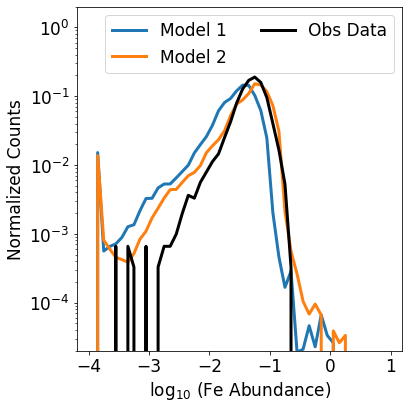

In [11]:
#
#
# Plot and compare the PDFs for the Iron Abundance
# between the observed data and the models.
#
# Indeed, you can see visually that model 2 does
# better.
#
fig,ax=plt.subplots()
fig.set_size_inches(6,6)

ax.set_xlabel(r'log$_{10}$ (Fe Abundance)')
ax.set_ylabel(r'Normalized Counts')

hist, bins = np.histogram(all_df['model-one']['fe_over_h'], 
                          bins = np.arange(-4,1.01,0.1), weights = all_df['model-one'].mass)
cent = (bins[1:]+bins[:-1])*0.5
ax.plot(cent, hist/(np.sum(hist)*1.0), lw = 3, color = 'C0', label = 'Model 1')

hist, bins = np.histogram(all_df['model-two']['fe_over_h'],
                          bins = bins, weights = all_df['model-two'].mass)
ax.plot(cent, hist/(np.sum(hist)*1.0), lw = 3, color = 'C1', label = 'Model 2')

hist, bins = np.histogram(obs_df['Fe_H'], bins = bins)
ax.plot(cent, hist/(np.sum(hist)*1.0), lw = 3, color = 'black', label = 'Obs Data')

ax.legend(loc='upper right', ncol=2)
ax.semilogy()
ax.set_ylim(2.0E-5,2.0)
plt.tight_layout()

# Where to Go From Here?

Development from here involves:

1) Computing the likelihood simultaneously for multiple elements and abundance ratios, and potentially additional quantities like stellar age.

2) Fully develop all example models to test

3) Link these models and likelihood computation to existing online interface to allow anyone to test / compare any observed dataset against different models

# Extra Plots / Analysis

## What is the Typical Error in Post-Processing?

Can we trust this post-processing model? What are the typical errors?

Text(0, 0.5, 'Cumulative Fraction')

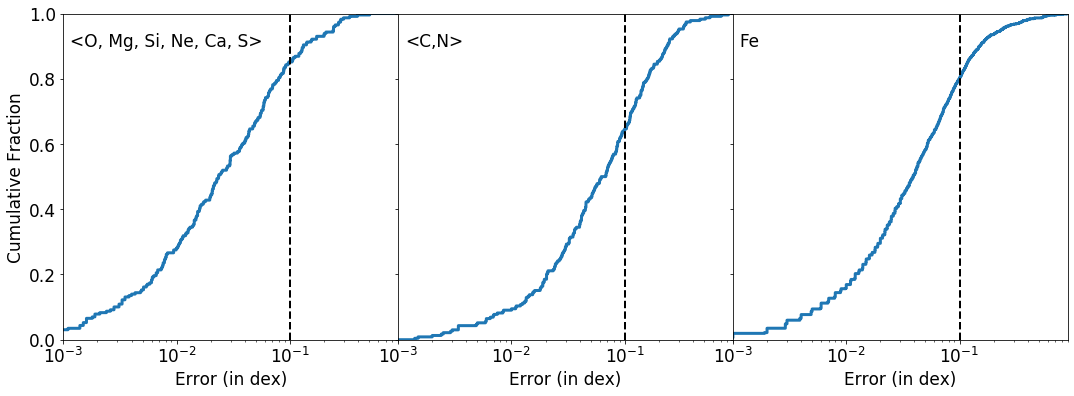

In [89]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True)
fig.set_size_inches(18,6)
fig.subplots_adjust(wspace=0,hspace=0)

#
# group elements by type
#
for axi,element_group in enumerate([['o','mg','si','ne','ca','s'],['c','n'],['fe']]):
    
    diff = np.zeros(all_df['live-simulation'].mass.size)
    for e in element_group:
        field = e + '_over_h'
        diff       = diff + all_df['live-simulation'][field].values - all_df['model-one'][field].values
    diff = diff / (1.0*(len(element_group)))
    
    
    diff_stats = compute_statistics(diff, weights = all_df['live-simulation'].mass.values)
    hist, bins = np.histogram(diff, bins = np.arange(0.0001,2.0,0.0001))
    bins_mid = 0.5 * (bins[:-1] + bins[1:])
    
    cum_hist = np.cumsum(hist)
    ax[axi].step(bins_mid, cum_hist / cum_hist[-1], where='mid', lw = 3)
    ax[axi].semilogx()
    ax[axi].set_ylim(0.0,1.0)
    ax[axi].set_xlim(0.001,0.9)
    
    ax[axi].plot([0.1,0.1], ax[axi].get_ylim(), lw = 2, ls = '--', color = 'black')
    
    
    ax[axi].set_xlabel(r'Error (in dex)')

xy = (0.02, 0.9)
ax[0].annotate(r"<O, Mg, Si, Ne, Ca, S>", xy, xytext=xy, xycoords='axes fraction')
ax[1].annotate(r"<C,N>", xy, xytext=xy, xycoords='axes fraction')
ax[2].annotate(r"Fe", xy, xytext=xy, xycoords='axes fraction')
ax[0].set_ylabel(r'Cumulative Fraction')
#plt.tight_layout()

## Which Fields Show the Largest Differences?

It is important to consider which of the available abundance measurements contain the largest differences, and thus which are likely the best bets to observe well in order to maximize the constraining power of the observations when comparing to the models (a.k.a. if two models predict the same values for a certain abundance, there is no benifit to observing that element well).

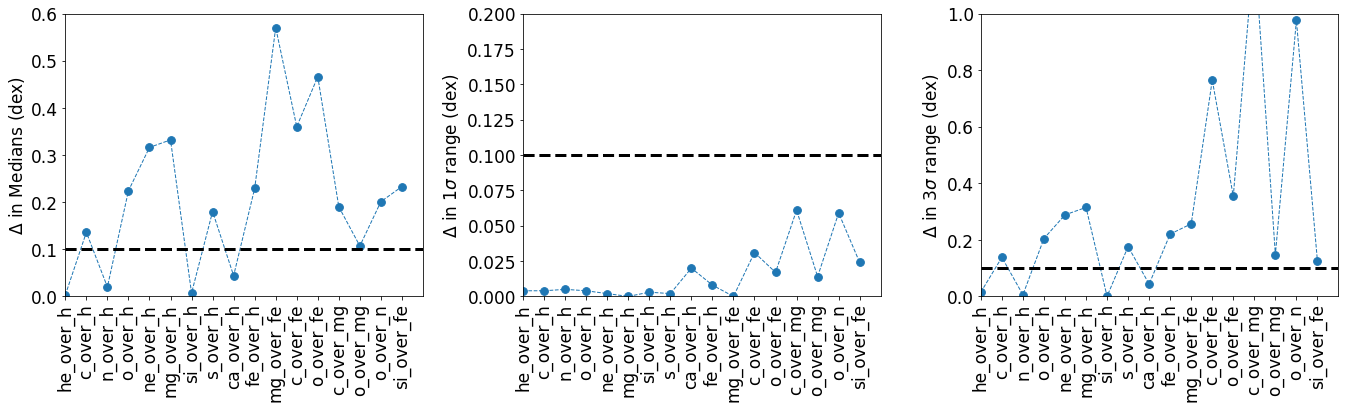

In [54]:
fields = [x for x in all_df['model-one'].columns if '_over_' in x]

median = np.zeros(np.size(fields))
sigma1 = np.zeros(np.size(fields))
sigma2 = np.zeros(np.size(fields))
for i,field in enumerate(fields):
    s0 = compute_statistics(all_df['model-one'][field], weights=all_df['model-one']['mass'])
    s1 = compute_statistics(all_df['model-two'][field], weights=all_df['model-two']['mass'])    
    
    median[i] = np.abs(s1['median'] - s0['median'])
    sigma1[i] = np.abs(s1['1-sigma_range'] - s0['1-sigma_range'])
    sigma2[i] = np.abs(s1['3-sigma_range'] - s0['3-sigma_range'])
    

fig,ax = plt.subplots(1,3)
fig.set_size_inches(19,6)

ps = 60

ax[0].scatter(range(len(fields)), median, s = ps)
ax[0].plot(range(len(fields)), median, lw = 1, ls = '--')
ax[0].set_ylim(0,0.6)
ax[0].set_ylabel(r'$\Delta$ in Medians (dex)')

ax[1].scatter(range(len(fields)), sigma1, s = ps)
ax[1].plot(range(len(fields)), sigma1, lw = 1, ls = '--')

ax[1].set_ylim(0,0.2)
ax[1].set_ylabel(r'$\Delta$ in 1$\sigma$ range (dex)')


ax[2].scatter(range(len(fields)), sigma2, s = ps)
ax[2].plot(range(len(fields)), sigma2, lw = 1, ls = '--')
ax[2].set_ylim(0,1.0)
ax[2].set_ylabel(r'$\Delta$ in 3$\sigma$ range (dex)')

for i in range(3):
    ax[i].set_xlim(0,len(fields))
    ax[i].set_xticks(range(len(fields)))
    _dummy = ax[i].set_xticklabels(fields,rotation=90)
    ax[i].plot(ax[i].get_xlim(), [0.1,0.1], lw = 3, color = 'black', ls='--')

plt.tight_layout()